In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patches as patches
import os
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
import datetime
import pandas as pd
import matplotlib.dates as mdates

In [2]:
#data check
#another way to check the era5 data
ds_era = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/era5/2021.h5')
ds_era

<xarray.Dataset>
Dimensions:  (phony_dim_0: 1460, phony_dim_1: 20, phony_dim_2: 721,
              phony_dim_3: 1440)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3
Data variables:
    fields   (phony_dim_0, phony_dim_1, phony_dim_2, phony_dim_3) float32 ...

In [4]:
#phony_dim_0: 1460(timestep); phony_dim_1: 20(variable); phony_dim_2: 721(longitude); phony_dim_3: 144(latitude)


#fcn-based on ECMWF initial conditions plots


ds_fcn_ecmwf = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210704_00_backtransformed.nc')
ds_fcn_ecmwf

ds_fcn_ecmwf.forecast[50,0,2,::-1,:]
ds_era.fields[709,2,260:40:-1,720:1200]

ds_ecmwf = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_cf_20210614_00_sfc.nc')
ds_ecmwf

lon_ec = ds_ecmwf['longitude']
lat_ec = ds_ecmwf['latitude']

lon_ec

<xarray.DataArray 'longitude' (longitude: 481)>
array([-180.  , -179.75, -179.5 , ...,  -60.5 ,  -60.25,  -60.  ],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... -60.5 -60.25 -60.0
Attributes:
    units:      degrees_east
    long_name:  longitude

In [5]:
#check for the index of lat and lon for the box-ecmwf
rightlon = -95.0
leftlon = -145.0
toplat = 75.0
bottomlat = 30.0

indices_toplat = np.where(lat_ec == toplat)[0]
indices_bottomlat = np.where(lat_ec == bottomlat)[0]
indices_rightlon = np.where(lon_ec == rightlon)[0]
indices_leftlon = np.where(lon_ec == leftlon)[0]

In [6]:
indices_toplat

array([20])

In [7]:
indices_bottomlat

array([200])

In [8]:
indices_rightlon

array([340])

In [9]:
indices_leftlon

array([140])

In [10]:
#era5 file index checking
# Assuming you have longitude and latitude arrays with 0.25-degree resolution
lat = np.linspace(25, 80, 220)
lon = np.linspace(-180, -60, 480)

rightlon = -95.0
leftlon = -145.0
toplat = 75.0
bottomlat = 30.0
# Calculate the indices for the desired grid point
rightlon_index = int(round((rightlon - lon[0]) / 0.25))
leftlon_index = int(round((leftlon - lon[0]) / 0.25))
toplat_index = int(round((lat[0]-toplat) / 0.25))
bottomlat_index = int(round((lat[0]-bottomlat) / 0.25))

In [11]:
rightlon_index

340

In [12]:
leftlon_index

140

In [13]:
toplat_index

-200

In [14]:
bottomlat_index

-20

In [15]:
ds_fcn_ecmwf = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210704_00_backtransformed.nc')
ds_fcn_ecmwf.forecast['phony_dim_3']

<xarray.DataArray 'phony_dim_3' (phony_dim_3: 220)>
array([  0,   1,   2, ..., 217, 218, 219])
Coordinates:
  * phony_dim_3  (phony_dim_3) int64 0 1 2 3 4 5 6 ... 214 215 216 217 218 219

In [21]:
#ECMWF
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_pf_\d{8}_\d{2}_pl\.nc'

files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
files

['fc_pf_20210614_00_pl.nc',
 'fc_pf_20210615_00_pl.nc',
 'fc_pf_20210616_00_pl.nc',
 'fc_pf_20210617_00_pl.nc',
 'fc_pf_20210618_00_pl.nc',
 'fc_pf_20210619_00_pl.nc',
 'fc_pf_20210620_00_pl.nc',
 'fc_pf_20210621_00_pl.nc',
 'fc_pf_20210622_00_pl.nc',
 'fc_pf_20210623_00_pl.nc',
 'fc_pf_20210624_00_pl.nc',
 'fc_pf_20210625_00_pl.nc',
 'fc_pf_20210626_00_pl.nc',
 'fc_pf_20210627_00_pl.nc',
 'fc_pf_20210628_00_pl.nc',
 'fc_pf_20210629_00_pl.nc',
 'fc_pf_20210630_00_pl.nc',
 'fc_pf_20210701_00_pl.nc',
 'fc_pf_20210702_00_pl.nc',
 'fc_pf_20210703_00_pl.nc',
 'fc_pf_20210704_00_pl.nc']

In [ ]:
data_ec = []
for file in files:
    file_path = os.path.join(directory, file)
    # Extract the date from the filename
    #date_str = re.search(r'\d{8}_\d{2}', file).group(0)
    #date = datetime.datetime.strptime(date_str, '%Y%m%d_%H').date()
    # Read the file and extract the desired variable
    ds = xr.open_dataset(file_path)
    variable_data = ds['z'][:,:,2,:,:]

    #time_coord = xr.DataArray([date], dims='time1', coords={'time1': [date]})
    #variable_data = variable_data.expand_dims(dim='time1')
    #variable_data = variable_data.assign_coords(time=time_coord)

    data_ec.append(variable_data)

#combined_data = xr.concat(data, dim='time1')
#combined_data
#combined_data[0,:,119,234]
np.shape(data_ec)

#ds_ecmwf.t2m[0,79:159,194:274]
data_array_ec =xr.DataArray(data_ec)
data_array_ec
#data_array_ec[:,0,0,0]

In [3]:
mean_ecmwf = np.mean(data_array_ec[:,:,:,:], axis=(-2, -1))
mean_ecmwf

NameError: name 'data_array_ec' is not defined

In [7]:
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210615_00_pl.nc') 
variable_data_ec_1 = ds_ec_1['z'][56,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

In [8]:
ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210616_00_pl.nc') 
variable_data_ec_2 = ds_ec_2['z'][52,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210617_00_pl.nc') 
variable_data_ec_3 = ds_ec_3['z'][48,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210618_00_pl.nc') 
variable_data_ec_4 = ds_ec_4['z'][44,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210619_00_pl.nc') 
variable_data_ec_5 = ds_ec_5['z'][40,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210620_00_pl.nc') 
variable_data_ec_6 = ds_ec_6['z'][36,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210621_00_pl.nc') 
variable_data_ec_7 = ds_ec_7['z'][32,:,2,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210622_00_pl.nc') 
variable_data_ec_8 = ds_ec_8['z'][28,:,2,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210623_00_pl.nc') 
variable_data_ec_9 = ds_ec_9['z'][24,:,2,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210624_00_pl.nc') 
variable_data_ec_10 = ds_ec_10['z'][20,:,2,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210625_00_pl.nc') 
variable_data_ec_11 = ds_ec_11['z'][16,:,2,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210626_00_pl.nc') 
variable_data_ec_12 = ds_ec_12['z'][12,:,2,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210627_00_pl.nc') 
variable_data_ec_13 = ds_ec_13['z'][8,:,2,:,:]

ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210628_00_pl.nc') 
variable_data_ec_14 = ds_ec_14['z'][4,:,2,:,:]

ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210629_00_pl.nc') 
variable_data_ec_15 = ds_ec_15['z'][0,:,2,:,:]

In [9]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [13]})

In [10]:
ds_ec_z500_wider = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

In [11]:
ds_ec_z500_wider

<xarray.DataArray 'z' (time: 15, number: 50, latitude: 221, longitude: 481)>
array([[[[53570.066, 53550.066, 53530.066, ..., 53698.566, 53692.566,
          53686.566],
         [53545.94 , 53525.566, 53505.19 , ..., 53764.44 , 53760.19 ,
          53755.816],
         [53522.816, 53502.316, 53481.69 , ..., 53822.69 , 53819.69 ,
          53816.69 ],
         ...,
         [57838.69 , 57833.44 , 57827.816, ..., 58016.816, 58024.69 ,
          58033.066],
         [57833.066, 57828.44 , 57822.69 , ..., 58015.69 , 58023.316,
          58031.94 ],
         [57827.19 , 57822.316, 57816.19 , ..., 58014.816, 58022.066,
          58030.44 ]],

        [[52483.1  , 52478.35 , 52473.477, ..., 52022.6  , 52017.977,
          52012.977],
         [52516.727, 52512.6  , 52508.35 , ..., 52067.477, 52062.6  ,
          52057.6  ],
         [52548.727, 52544.977, 52541.227, ..., 52112.1  , 52107.227,
          52102.227],
...
         [58158.625, 58155.125, 58150.625, ..., 57932.125, 57929.375,
          57929.125],
         [58150.625, 58147.625, 58144.375, ..., 57939.875, 57936.625,
          57933.875],
         [58140.375, 58137.875, 58136.375, ..., 57946.375, 57944.875,
          57942.875]],

        [[50293.7  , 50282.2  , 50270.7  , ..., 52469.95 , 52473.45 ,
          52476.95 ],
         [50340.45 , 50329.45 , 50318.2  , ..., 52465.7  , 52468.95 ,
          52472.2  ],
         [50394.7  , 50384.45 , 50373.95 , ..., 52461.7  , 52464.7  ,
          52467.95 ],
         ...,
         [58140.7  , 58136.7  , 58132.45 , ..., 57955.2  , 57950.95 ,
          57948.2  ],
         [58130.95 , 58127.45 , 58123.7  , ..., 57960.45 , 57956.7  ,
          57953.7  ],
         [58122.45 , 58119.95 , 58118.2  , ..., 57967.95 , 57965.2  ,
          57962.2  ]]]], dtype=float32)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 13
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... -60.5 -60.25 -60.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 25.5 25.25 25.0
    level      int32 500
  * number     (number) int32 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [12]:
ds_ec_z500_wider_mean = np.mean(ds_ec_z500_wider,axis = (2,3))

([<matplotlib.axis.XTick at 0x14c1dc4f1340>,
 [Text(1, 0, 'Jun 15'),
  Text(2, 0, 'Jun 16'),
  Text(3, 0, 'Jun 17'),
  Text(4, 0, 'Jun 18'),
  Text(5, 0, 'Jun 19'),
  Text(6, 0, 'Jun 20'),
  Text(7, 0, 'Jun 21'),
  Text(8, 0, 'Jun 22'),
  Text(9, 0, 'Jun 23'),
  Text(10, 0, 'Jun 24'),
  Text(11, 0, 'Jun 25'),
  Text(12, 0, 'Jun 26'),
  Text(13, 0, 'Jun 27'),
  Text(14, 0, 'Jun 28'),
  Text(15, 0, 'Jun 29')])

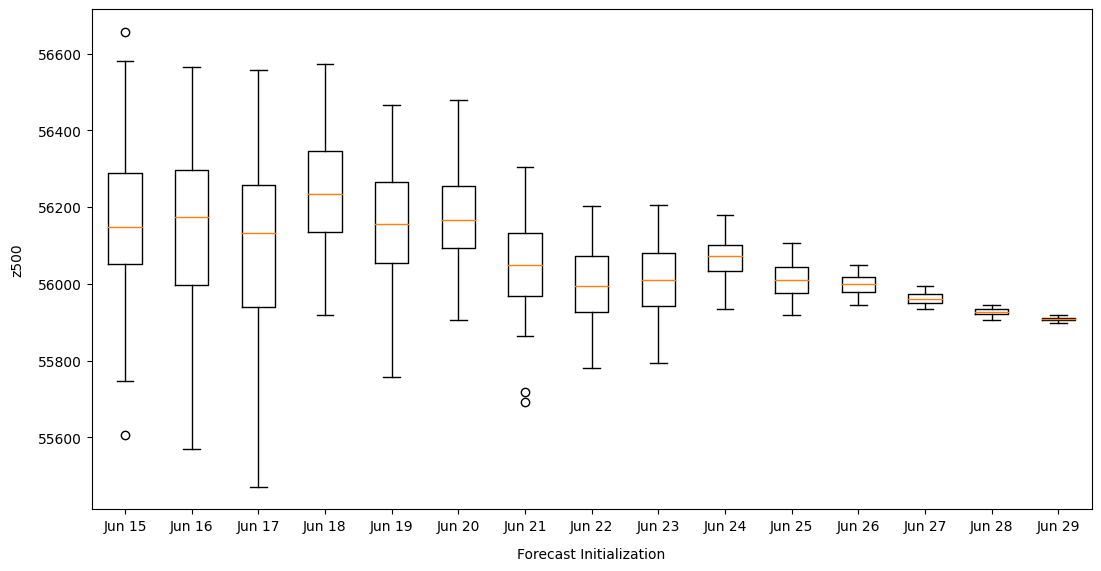

In [13]:

#boxplot
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Forecast Initialization", labelpad=10)
ax.set_ylabel("z500", labelpad=10)
#ax.plot(df, 'o', color='black',label='ECMWF')
data=ds_ec_z500_wider_mean.T
ax.boxplot(data)
#ax.axhline(y=mean_era5_06_29, color='r', linestyle='-',label = 'ERA5')
#plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15],
           ["Jun 15", "Jun 16", "Jun 17", "Jun 18", "Jun 19", "Jun 20", "Jun 21","Jun 22", "Jun 23", "Jun 24", "Jun 25", "Jun 26", "Jun 27", 
               "Jun 28", "Jun 29"])

In [15]:
#fcn_era5
ds_fcn_era = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/2021_dt_list_ens_backtransformed.nc',engine = 'netcdf4')
ds_fcn_era
fcn_era_z = ds_fcn_era.forecast[:,:,:,14,:,:]

In [16]:
variable_data_ec_1 = fcn_era_z[1,:,56,:,:]


variable_data_ec_2 = fcn_era_z[2,:,52,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))


variable_data_ec_3 = fcn_era_z[3,:,48,:,:]

variable_data_ec_4 = fcn_era_z[4,:,44,:,:]

variable_data_ec_5 = fcn_era_z[5,:,40,:,:]

variable_data_ec_6 = fcn_era_z[6,:,36,:,:]

variable_data_ec_7 = fcn_era_z[7,:,32,:,:]

variable_data_ec_8 = fcn_era_z[8,:,28,:,:]

variable_data_ec_9 = fcn_era_z[9,:,24,:,:]

variable_data_ec_10 = fcn_era_z[10,:,20,:,:]

variable_data_ec_11 = fcn_era_z[12,:,16,:,:]

variable_data_ec_12 = fcn_era_z[13,:,12,:,:]

variable_data_ec_13 = fcn_era_z[14,:,8,:,:]

variable_data_ec_14 = fcn_era_z[15,:,4,:,:]

variable_data_ec_15 = fcn_era_z[16,:,0,:,:]

In [17]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [18]:
ds_fc_era_z500_wider = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

In [19]:
ds_fc_era_z500_wider_mean = np.mean(ds_fc_era_z500_wider,axis = (2,3))

([<matplotlib.axis.XTick at 0x14c1ef986070>,
 [Text(1, 0, 'Jun 15'),
  Text(2, 0, 'Jun 16'),
  Text(3, 0, 'Jun 17'),
  Text(4, 0, 'Jun 18'),
  Text(5, 0, 'Jun 19'),
  Text(6, 0, 'Jun 20'),
  Text(7, 0, 'Jun 21'),
  Text(8, 0, 'Jun 22'),
  Text(9, 0, 'Jun 23'),
  Text(10, 0, 'Jun 24'),
  Text(11, 0, 'Jun 25'),
  Text(12, 0, 'Jun 26'),
  Text(13, 0, 'Jun 27'),
  Text(14, 0, 'Jun 28'),
  Text(15, 0, 'Jun 29')])

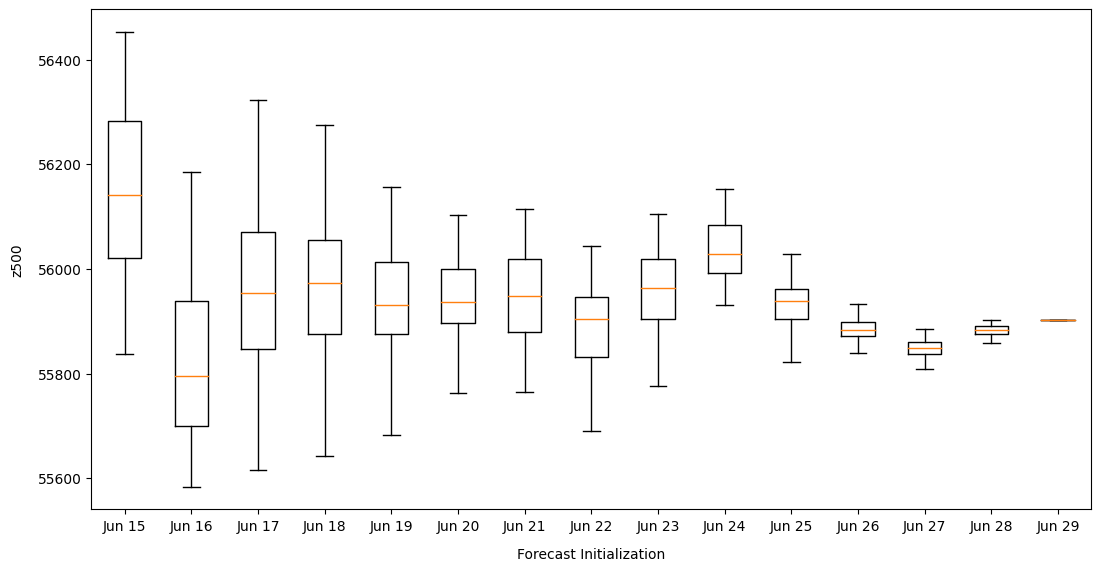

In [20]:
#boxplot
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Forecast Initialization", labelpad=10)
ax.set_ylabel("z500", labelpad=10)
#ax.plot(df, 'o', color='black',label='ECMWF')
data=ds_fc_era_z500_wider_mean[:,0:50].T
ax.boxplot(data,showfliers = False)
#ax.axhline(y=mean_era5_06_29, color='r', linestyle='-',label = 'ERA5')
#plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15],
           ["Jun 15", "Jun 16", "Jun 17", "Jun 18", "Jun 19", "Jun 20", "Jun 21","Jun 22", "Jun 23", "Jun 24", "Jun 25", "Jun 26", "Jun 27", 
               "Jun 28", "Jun 29"])

In [21]:
ds_ec_1 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210615_00_backtransformed.nc') 
variable_data_ec_1 = ds_ec_1['forecast'][:,56,14,:,:]




ds_ec_2 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210616_00_backtransformed.nc') 
variable_data_ec_2 = ds_ec_2['forecast'][:,52,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210617_00_backtransformed.nc') 
variable_data_ec_3 = ds_ec_3['forecast'][:,48,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210618_00_backtransformed.nc') 
variable_data_ec_4 = ds_ec_4['forecast'][:,44,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210619_00_backtransformed.nc') 
variable_data_ec_5 = ds_ec_5['forecast'][:,40,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210620_00_backtransformed.nc') 
variable_data_ec_6 = ds_ec_6['forecast'][:,36,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210621_00_backtransformed.nc') 
variable_data_ec_7 = ds_ec_7['forecast'][:,32,14,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210622_00_backtransformed.nc') 
variable_data_ec_8 = ds_ec_8['forecast'][:,28,14,:,:]

ds_ec_9 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210623_00_backtransformed.nc') 
variable_data_ec_9 = ds_ec_9['forecast'][:,24,14,:,:]

ds_ec_10 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210624_00_backtransformed.nc') 
variable_data_ec_10 = ds_ec_10['forecast'][:,20,14,:,:]

ds_ec_11 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210625_00_backtransformed.nc') 
variable_data_ec_11 = ds_ec_11['forecast'][:,16,14,:,:]

ds_ec_12 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210626_00_backtransformed.nc') 
variable_data_ec_12 = ds_ec_12['forecast'][:,12,14,:,:]

ds_ec_13 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210627_00_backtransformed.nc') 
variable_data_ec_13 = ds_ec_13['forecast'][:,8,14,:,:]

ds_ec_14 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210628_00_backtransformed.nc') 
variable_data_ec_14 = ds_ec_14['forecast'][:,4,14,:,:]
ds_ec_15 = xr.open_dataset('/pfs/work7/workspace/scratch/ab6801-fourcastnet/fourcastnet/with_ecmwf_ic/20210629_00_backtransformed.nc') 
variable_data_ec_15 = ds_ec_15['forecast'][:,0,14,:,:]

In [22]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [13]})

In [23]:
ds_fc_ec_z500_wider = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

In [24]:
ds_fc_ec_z500_wider_mean = np.mean(ds_fc_ec_z500_wider,axis = (2,3))

([<matplotlib.axis.XTick at 0x14c1ef59a970>,
 [Text(1, 0, 'Jun 15'),
  Text(2, 0, 'Jun 16'),
  Text(3, 0, 'Jun 17'),
  Text(4, 0, 'Jun 18'),
  Text(5, 0, 'Jun 19'),
  Text(6, 0, 'Jun 20'),
  Text(7, 0, 'Jun 21'),
  Text(8, 0, 'Jun 22'),
  Text(9, 0, 'Jun 23'),
  Text(10, 0, 'Jun 24'),
  Text(11, 0, 'Jun 25'),
  Text(12, 0, 'Jun 26'),
  Text(13, 0, 'Jun 27'),
  Text(14, 0, 'Jun 28'),
  Text(15, 0, 'Jun 29')])

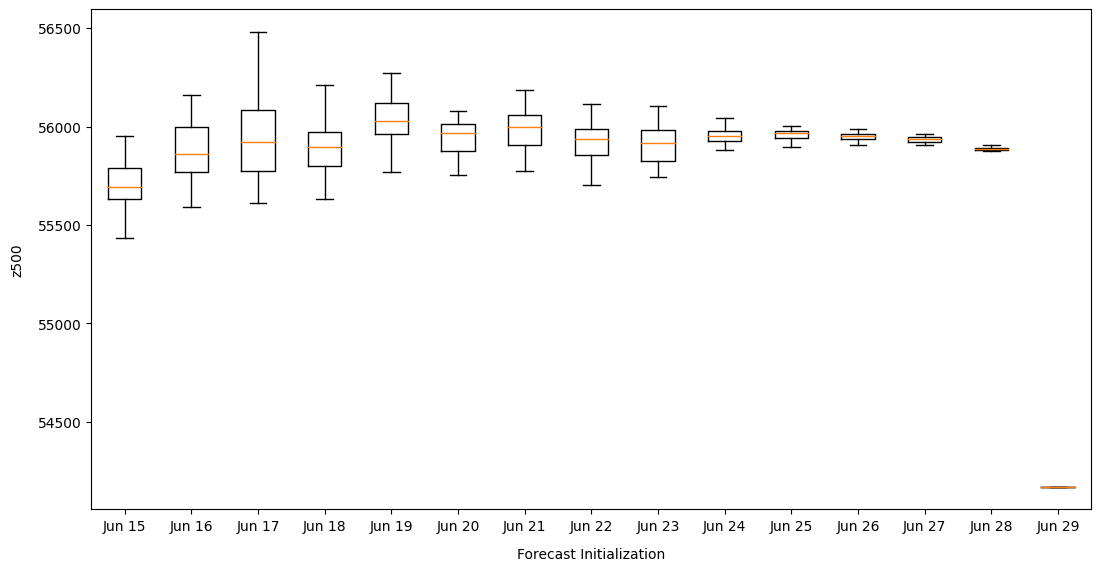

In [25]:
#boxplot
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Forecast Initialization", labelpad=10)
ax.set_ylabel("z500", labelpad=10)
#ax.plot(df, 'o', color='black',label='ECMWF')
data=ds_fc_ec_z500_wider_mean[:,1:51].T
ax.boxplot(data,showfliers = False)
#ax.axhline(y=mean_era5_06_29, color='r', linestyle='-',label = 'ERA5')
#plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15],
           ["Jun 15", "Jun 16", "Jun 17", "Jun 18", "Jun 19", "Jun 20", "Jun 21","Jun 22", "Jun 23", "Jun 24", "Jun 25", "Jun 26", "Jun 27", 
               "Jun 28", "Jun 29"])

In [26]:
import matplotlib.pyplot as pl
#%store -r data_array_fc_ec_values_850hpa
colors = [ 'lightblue','lightgreen','lightpink']


# we compare the performances of the 4 individuals within the same set of 3 settings 
data_groups = [(ds_ec_z500_wider_mean.values/9.806659).T,(ds_fc_era_z500_wider_mean.values/9.80665).T,(ds_fc_ec_z500_wider_mean.values/9.80665).T]
#np.shape(data_groups)

-1.0
0.0
1.0


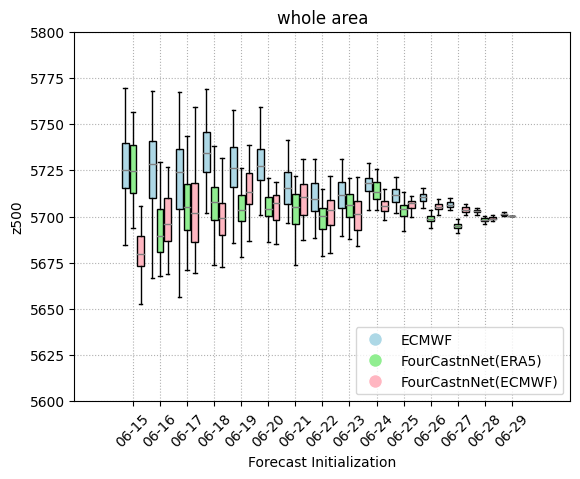

In [30]:
# --- Labels for your data:
labels_list = ['06-15','06-16','06-17','06-18','06-19','06-20','06-21','06-22','06-23','06-24','06-25','06-26','06-27','06-28','06-29']
width       = 1/len(labels_list)
width

xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(ds_ec_z500_wider_mean[:,:])) ]
xlocations

symbol      = 'r+'
ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])
ymax 



ax = pl.gca()
ax.set_ylim(5600,5800)
ax.grid(True, linestyle='dotted')
ax.set_axisbelow(True)

pl.xlabel('Forecast Initialization')
pl.ylabel('z500')
#pl.title('title')

space = len(data_groups)/2
offset = len(data_groups)/2
offset

xlocations

# --- Offset the positions per group:

group_positions = []
for num, dg in enumerate(data_groups):    
    _off = (0 - space + (0.5+num))
    print(_off)
    group_positions.append([x+_off*(width+0.01) for x in xlocations])

group_positions

data_groups
len(labels_list)

for dg, pos, c in zip(data_groups, group_positions, colors):
    boxes = ax.boxplot(dg, 
                sym=symbol,
                labels=['']*len(labels_list),
    #            labels=labels_list,
                positions=pos, 
                widths=width, 
                boxprops=dict(facecolor=c),
    #             capprops=dict(color=c),
    #            whiskerprops=dict(color=c),
    #            flierprops=dict(color=c, markeredgecolor=c),                       
                medianprops=dict(color='grey'),
    #           notch=False,  
    #           vert=True, 
    #           whis=1.5,
    #           bootstrap=None, 
    #           usermedians=None, 
    #           conf_intervals=None,
                patch_artist=True,showfliers=False
                )
%store -r mean_era5_06_29
#line_artists = []
#line = plt.axhline(y=ds_era_z500_mean/9.80665, color='r', linestyle='-',label = 'ERA5')
#line_artists.append(line)


ax.set_xticks( xlocations )
ax.set_xticklabels( labels_list, rotation=45 )


legend_labels = ['ECMWF','FourCastnNet(ERA5)','FourCastnNet(ECMWF)']
legend_handles = [plt.Line2D([0], [0],marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(legend_labels[:], colors) ]#+ line_artists 
plt.legend(handles=legend_handles, loc='lower right')
plt.title('whole area')
#plt.savefig('/home/kit/imk-tro/gj5173/21.09_boxplot/850_ts_ensemble_3togther.png', bbox_inches='tight',dpi=100)

pl.show()